<a href="https://colab.research.google.com/github/seoyeon0905/mimic-readmission-analysis/blob/main/notebooks/04_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab session setup
%cd /content
!rm -rf mimic-readmission-analysis
!git clone https://github.com/seoyeon0905/mimic-readmission-analysis.git
%cd mimic-readmission-analysis

/content
Cloning into 'mimic-readmission-analysis'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 188 (delta 20), reused 5 (delta 5), pack-reused 155 (from 1)
Receiving objects: 100% (188/188), 493.86 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/mimic-readmission-analysis


In [ ]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 04_baseline_model.ipynb의 목표
- EDA에서 확인한 사실을 바탕으로 단순하지만 정직한 예측 모델을 만들고 올바른 평가 지표로 성능을 해석
- EDA에서 본 사실을 바탕으로 단순한 모델이 어디까지 가능한지를 수치로 보여주는 기준점(baseline) 만들기

# 04. Baseline 예측 모델링

이 노트북에서는 기본적인 인구학적 및 임상 변수만을 사용하여
30일 이내 ICU 재입원을 얼마나 잘 예측할 수 있는지 평가하기 위한
간단한 기준선(baseline) 예측 모델을 구축한다.

탐색적 데이터 분석(EDA) 결과를 바탕으로,
단일 변수만으로는 예측력이 제한적일 것으로 예상하며,
이후 단계의 모델링 성능을 비교하기 위한
참조 성능(reference performance)을 설정하는 데 목적이 있다.

# 데이터 로드(EDA와 동일한 csv)

In [ ]:
# 작업위치(폴더)를 notebooks로 변경하기
# 그 작업위치(폴더)에 어떤 파일이 있는지 확인하기
%cd notebooks
!ls

/content/mimic-readmission-analysis/notebooks
01_data_loading.ipynb	    03_readmission_eda.ipynb
02_cohort_definition.ipynb  04_baseline_model.ipynb


In [ ]:
# 데이터 로드(EDA와 동일한 csv)
df = pd.read_csv("../data/processed/first_icu_admissions.csv")

# Baseline feature 선택(중요한 판단 포인트)
## EDA 결과를 그대로 반영하면:
- age -> 약한 정보
- icu_los -> 약한 positive signal
- gender -> 거의 없음(baseline에서는 제외해도 됨)

In [ ]:
# X, y만들기(모델 입력 / 정답 만들기)
# 모델에게 줄 "힌트(X)"와 "정답(y)"를 분리해야 학습/평가가 가능
# Feature / Target 설정

features = ['age', 'icu_los']
target = 'readmitted_30d'

x = df[features]
y = df[target]

In [ ]:
print("x shape:", x.shape)
print("y shape:", y.shape)
print("Target distribution:\n", y.value_counts())
# x shape: (100, 2)
# y shape: (100,)
# y 분포가 0:92, 1:8 정도 나오면 정상

x shape: (100, 2)
y shape: (100,)
Target distribution:
 readmitted_30d
0    92
1     8
Name: count, dtype: int64


# Train/Test split(공부 / 시험 데이터 나누기)
모델이 외운 실력이 아니라 처음 보는 데이터에 대한 실력을 평가하려고

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size = 0.3,  # 30%는 시험용
    random_state = 42,  # 결과 고정(재현성)
    stratify = y  # 불균형 유지
)

In [ ]:
print("Train size:", x_train.shape[0])
print("Test size:", x_test.shape[0])

print("\nTrain label distribution:\n", y_train.value_counts())
print("\nTest label distribution:\n", y_test.value_counts())
# Train size: 70, Test size: 30
# Test에도 1이 최소 1개 이상 있어야 정상
# 없으면 stratify가 제대로 안 된 거라 다시 봐야 함

Train size: 70
Test size: 30

Train label distribution:
 readmitted_30d
0    64
1     6
Name: count, dtype: int64

Test label distribution:
 readmitted_30d
0    28
1     2
Name: count, dtype: int64


# Navie baseline(전부 0으로 찍어보기)
아무 모델도 안 써도 나올 수 있는 성능이 어느 정도인지 기준점을 만들기 위해서

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# 전부 0으로 예측
y_pred_naive = np.zeros_like(y_test)

In [ ]:
print("=== Naive Baseline (all 0) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_naive))
print("Recall:", recall_score(y_test, y_pred_naive, zero_division=0))
print("Precision:", precision_score(y_test, y_pred_naive, zero_division=0))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_naive))
# Accuracy는 높게 나올 수 있음(0이 많으니까)
# Recall은 0일 가능성이 큼(1을 하나도 못 맞춤)
# Confusion Matrix에서 TP=0, FN>0이면 "재입원 환자를 못 잡음"의미

=== Naive Baseline (all 0) ===
Accuracy: 0.9333333333333333
Recall: 0.0
Precision: 0.0

Confusion Matrix:
 [[28  0]
 [ 2  0]]


# Logistic Regression 학습하기(진짜 baseline 모델)
- 모델링 처음 단계에서 가장 "기본 + 해석 가능"
- 불균형도 class_weight = 'balanced'로 어느 정도 대응 가능

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    class_weight = 'balanced',
    max_iter = 1000
)

log_reg.fit(x_train, y_train)

# 예측(0/1)
y_pred = log_reg.predict(x_test)

# 확률점수(재입원=1일 확률)
y_proba = log_reg.predict_proba(x_test)[:, 1]

In [ ]:
print("Logistic Regression fitted.")
print("Example probabilities:", y_proba[:10])
# Example probabilities에서 0~1 사이 값들이 나오면 정상

Logistic Regression fitted.
Example probabilities: [0.48118874 0.36397206 0.49600107 0.36257137 0.48978579 0.48721873
 0.46876771 0.44836183 0.49244947 0.28909225]


In [ ]:
# 대부분의 예측 확률이 0.3 ~ 0.5 근처에 분포함
# 이는 baseline feature만으로는 모델이 강한 판단 신호를 얻지 못했음을 시사

# 평가 지표 출력(여기가 핵심)
불균형 문제에서 accuracy만 보면 착시가 생기니까 Recall / AUROC / PR-AUC를 함께 봐야함

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
print("=== Logistic Regression Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))

print("AUROC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# 데이터가 1이 적기때문에
# AUROC가 0.5보다 조금만 높아도 "약한 신호"
# PR-AUC는 낮게 나오는 게 정상(rare event니까)

=== Logistic Regression Performance ===
Accuracy: 0.8666666666666667
Precision: 0.0
Recall: 0.0
AUROC: 0.4821428571428572
PR-AUC: 0.09109311740890688

Confusion Matrix:
 [[26  2]
 [ 2  0]]


In [ ]:
# AUROC : 0.482
# 0.5보다 살짝 아래
# AUROC는0.5에 근접한 값을 보였으며 이는 매우 제한적인 feature구성과
# 작은 표본 크기로 인해 모델의 구분력이 거의 랜덤 수준임을 시사한다
# 이는 baseline 단계에서 기대 가능한 결과로
# 추가적인 임상 변수 도입의 필요성을 뒷받침한다.

In [ ]:
# confusion matrix : [[26 2] [2 0]]
# -> TP=0
# -> recall=0

# 기본 threshold(0.5)기준에서는 재입원 환자를 탐지하지 못했으나
# 이는 threshold 선택에 따른 결과이며
# ROC/PR curve는 threshold 조정 시 trade-off 가능성을 보여준다.

# Test set에서 재입원 환자 2명 모두를 놓쳤으며
# 이는 baseline 단계에서 기대 가능한 결과로
# 모델의 한계보다는 feature 정보 부족을 반영한다.

In [ ]:
# PR-AUC : 0.09
# positive rate = 0.08 이니까
# 이건 랜덤보다 아주 살짝 나은 수준
# PR-AUC는 positive rate 대비 소폭 높은 수준으로
# baseline feature에서 얻을 수 있는 신호가 매우 제한적임을 보여준다.

# ROC / PR Curve 그리기(시각화)

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

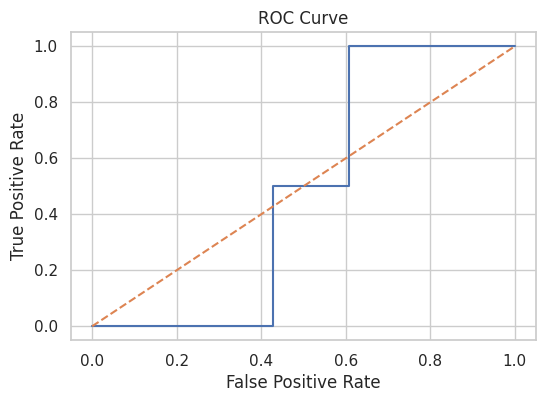

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print("Number of thresholds:", len(thresholds))
print("First 5 thresholds:", thresholds[:5])
# ROC에 쓰인 threshold가 여러 개라는게 바로 보임

Number of thresholds: 7
First 5 thresholds: [       inf 0.68363832 0.48550855 0.48118874 0.46876771]


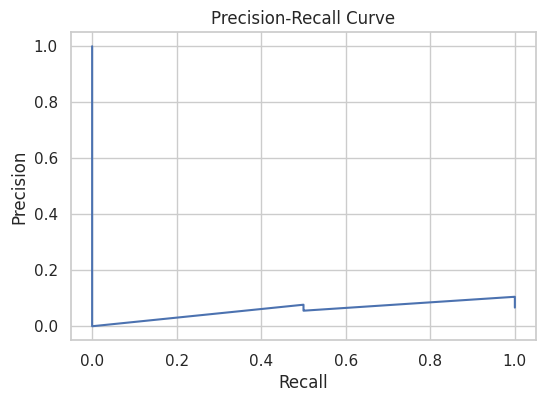

In [ ]:
# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
# 여기서는 곡선 모양만 봐도 됨
# 해석은 간단히 어렵다 / 신호 약하다 정도면 충분

# 계수 확인(해석하기)

In [ ]:
coef = pd.Series(log_reg.coef_[0], index=features).sort_values(ascending=False)
print("Logistic Regression Coefficients:")
print(coef)

Logistic Regression Coefficients:
age        0.003561
icu_los   -0.021873
dtype: float64


In [ ]:
# age 계수는 매우 작아 재입원 예측에 기여도가 거의 없음
# icu_los 계수는 음수로 나타났으며
# 본 baseline 모델에서는 ICU 재원 기간이 길수록
# 재입원 확률이 낮아지는 방향으로 학습되었음

In [ ]:
# 표본 수가 매우 작고(n=100, positive=8)
# 변수 2개짜리 단순 모델이며
# class_weight로 decision boundary가 이동했기 때문에 계수의 방향은 불안정할 수 있음

간단한 로지스틱 회귀 기반 baseline 모델을 통해
기본적인 인구학적 및 임상 변수만으로는
30일 이내 ICU 재입원을 충분히 잘 예측하기 어렵다는 점을 확인하였다.

특히 클래스 불균형으로 인해 accuracy는 적절한 평가 지표가 아니며
recall 및 PR-AUC와 같은 지표를 함께 고려해야 함을 보여준다.

이러한 결과는 이후 단계에서
진단 코드, 입원 정보 등 보다 풍부한 임상 변수와
더 표현력이 높은 모델을 도입할 필요성을 시사한다.

본 노트북의 목적은 높은 예측 성능을 달성하는 것이 아니라
단순한 변수 구성에서 얻을 수 있는 성능의 상한선을 확인하고
이후 모델링 단계의 비교 기준(baseline)을 제공하는 데 있다.